# 语义分割和数据集
:label:`sec_semantic_segmentation`

在 :numref:`sec_bbox`— :numref:`sec_rcnn`中讨论的目标检测问题中，我们一直使用方形边界框来标注和预测图像中的目标。
本节将探讨*语义分割*（semantic segmentation）问题，它重点关注于如何将图像分割成属于不同语义类别的区域。
与目标检测不同，语义分割可以识别并理解图像中每一个像素的内容：其语义区域的标注和预测是像素级的。
 :numref:`fig_segmentation`展示了语义分割中图像有关狗、猫和背景的标签。
与目标检测相比，语义分割标注的像素级的边框显然更加精细。

![语义分割中图像有关狗、猫和背景的标签](../img/segmentation.svg)
:label:`fig_segmentation`

## 图像分割和实例分割

计算机视觉领域还有2个与语义分割相似的重要问题，即*图像分割*（image segmentation）和*实例分割*（instance segmentation）。
我们在这里将它们同语义分割简单区分一下。

* *图像分割*将图像划分为若干组成区域，这类问题的方法通常利用图像中像素之间的相关性。它在训练时不需要有关图像像素的标签信息，在预测时也无法保证分割出的区域具有我们希望得到的语义。以 :numref:`fig_segmentation`中的图像作为输入，图像分割可能会将狗分为两个区域：一个覆盖以黑色为主的嘴和眼睛，另一个覆盖以黄色为主的其余部分身体。
* *实例分割*也叫*同时检测并分割*（simultaneous detection and segmentation），它研究如何识别图像中各个目标实例的像素级区域。与语义分割不同，实例分割不仅需要区分语义，还要区分不同的目标实例。例如，如果图像中有两条狗，则实例分割需要区分像素属于的两条狗中的哪一条。

## Pascal VOC2012 语义分割数据集

[**最重要的语义分割数据集之一是[Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/)。**]
下面我们深入了解一下这个数据集。


In [3]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

数据集的tar文件大约为2GB，所以下载可能需要一段时间。
提取出的数据集位于`../data/VOCdevkit/VOC2012`。


In [4]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

进入路径`../data/VOCdevkit/VOC2012`之后，我们可以看到数据集的不同组件。
`ImageSets/Segmentation`路径包含用于训练和测试样本的文本文件，而`JPEGImages`和`SegmentationClass`路径分别存储着每个示例的输入图像和标签。
此处的标签也采用图像格式，其尺寸和它所标注的输入图像的尺寸相同。
此外，标签中颜色相同的像素属于同一个语义类别。
下面将`read_voc_images`函数定义为[**将所有输入的图像和标签读入内存**]。


In [5]:
# 将所有输入的图像和标签读入内存，
#@save
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注, VOC格式现在也不错."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt') # 是训练数据集还是验证数据集.
    mode = torchvision.io.image.ImageReadMode.RGB # RGB彩色图片. 
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg'))) # 读取feature.
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode)) 
            # 语义分割的label需要对每个像素进行存储, 所以我们使用png是没有压缩的. 就是在对应的文件名存了一个对应的图片, (jpeg是压缩的。)
            # 训练样本是一个图片, 标号也是一个同样大小的图片, 每一个像素对应一个标号, 每个pixel的值对应的是标号.
    return features, labels # 返回. 

train_features, train_labels = read_voc_images(voc_dir, True) # 读取, 拿到训练样本. 

下面我们[**绘制前5个输入图像及其标签**]。
在标签图像中，白色和黑色分别表示边框和背景，而其他颜色则对应不同的类别。


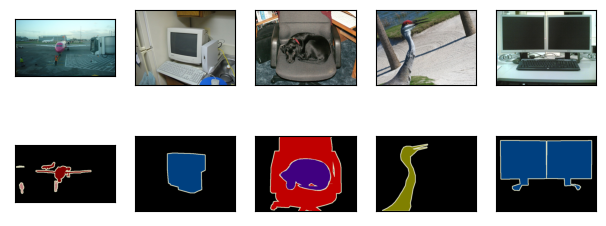

In [6]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs] # 画图的时候将channel放到最后一个维度.
d2l.show_images(imgs, 2, n);
# 背景是黑色, 边缘框是一个白色的线, 物体是各种各样的. 

接下来，我们[**列举RGB颜色值和类名**]。


In [7]:
# 列举RGB颜色值和类名. 每一个标号, 对应的pixel对应的类别标号
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

通过上面定义的两个常量，我们可以方便地[**查找标签中每个像素的类索引**]。
我们定义了`voc_colormap2label`函数来构建从上述RGB颜色值到类别索引的映射，而`voc_label_indices`函数将RGB值映射到在Pascal VOC2012数据集中的类别索引。


In [8]:
# 辅助函数: 将一个RGB换算成我们的标号. 
# 同理给一个标号我们也能够换算回我们的RGB值. 
# 如果我们真的是为每一个pixel计算标号, 那么python会很慢
# 所以使用映射表吧. 
#@save
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long) # 开一个大的数组.
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[ # 这里做了一个最简单的换算, 将RGB map成一个整数. 
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
            # 第i个RGB的值, 映射到i的这个地方. 
    return colormap2label

# 将VOC标签中的RGB值映射到他们的类别索引.
#@save
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引
        给你RGB, 然后给你dict, 然后转换.
        """
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx] # 拿出来对应位置上的索引, 就是标号值. 

[**例如**]，在第一张样本图像中，飞机头部区域的类别索引为1，而背景索引为0。


In [9]:

# 飞机那张图片: 
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1] 
# 最终的结果就是什么呢. 就是这张图片, 每一个像素, 对应的标号, 如果是0,表示背景, 如果是1表示飞机.
# 将RGB变成标号, 方便进行训练.

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

### 预处理数据

在之前的实验，例如 :numref:`sec_alexnet`— :numref:`sec_googlenet`中，我们通过再缩放图像使其符合模型的输入形状。
然而在语义分割中，这样做需要将预测的像素类别重新映射回原始尺寸的输入图像。
这样的映射可能不够精确，尤其在不同语义的分割区域。
为了避免这个问题，我们将图像裁剪为固定尺寸，而不是再缩放。
具体来说，我们[**使用图像增广中的随机裁剪，裁剪输入图像和标签的相同区域**]。


In [10]:
# 图片增广: 
# 使用图像增广中的随机剪裁,.剪裁输入图像和标签的相同区域. 
# 我们在实现裁剪的时, 我们也需要对标签进行裁剪. 

#@save
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = torchvision.transforms.RandomCrop.get_params( # 随机裁剪出来高宽的区域. 返回bounding box.
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect) # 拿到框, 然后真正的crop. 
    label = torchvision.transforms.functional.crop(label, *rect) # 对标号也同样做crop. 
    return feature, label

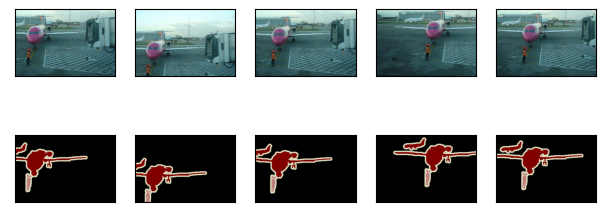

In [11]:
imgs = []
for _ in range(n): # 我们裁剪5次. 
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

# 所以做裁剪时我们一定要很小心, 就是我们需要将原始图片, 和label一起进行裁剪. 
# 我们要保证同样的数据增强, 我们需要对数据和label同样去做. 
# 这里是随机去做的, 就是我们要对数据和label固定住随机, 
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### [**自定义语义分割数据集类**]

我们通过继承高级API提供的`Dataset`类，自定义了一个语义分割数据集类`VOCSegDataset`。
通过实现`__getitem__`函数，我们可以任意访问数据集中索引为`idx`的输入图像及其每个像素的类别索引。
由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本可以通过自定义的`filter`函数移除掉。
此外，我们还定义了`normalize_image`函数，从而对输入图像的RGB三个通道的值分别做标准化。


In [12]:
# 定义我们的datasets:
# 我们使用crop还有一个原因, 就是resize, 就是使用相同大小的图片, 然后放进一个batch里.  
# 我们之前做图片分类我们是可以resize的. voc是数据集每张图片是不一样的, 而且不好resize. 因为resize时, 我们的label怎么拉伸
#   拉伸是通过插值来做的. 而label是不能随便插值的. 容易对应不到标号的. 所以语义分割不太好用resize的. 
# 所以一般都是直接crop, 或者使用不失真的resize.
#   

#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir): # crop后我们就不用resize了. 
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize, 归一化. 
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature) # 前处理.
                         for feature in self.filter(features)] # filter一下. 
        self.labels = self.filter(labels) # filter一下
        self.colormap2label = voc_colormap2label() # 构造. 
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255) # 使用transform

    def filter(self, imgs): # 假设我们图片非常小, 如果比我们裁剪的还要小, 所以我们干脆就不要了. 这就是过滤
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx): # 实例[]. 
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size) # 然后每一次对图片和label做一次随机crop. 
        return (feature, voc_label_indices(label, self.colormap2label)) # 然后标号换成我们的编号.
        

    def __len__(self):
        return len(self.features)

### [**读取数据集**]

我们通过自定义的`VOCSegDataset`类来分别创建训练集和测试集的实例。
假设我们指定随机裁剪的输出图像的形状为$320\times 480$，
下面我们可以查看训练集和测试集所保留的样本个数。


In [13]:
crop_size = (320, 480) # 最终的图片大小. 我们其实看了一些数据集里面的图片.
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)
# 一般来说标一个语义分割的数据集是比较贵的事情

read 1114 examples
read 1078 examples


设批量大小为64，我们定义训练集的迭代器。
打印第一个小批量的形状会发现：与图像分类或目标检测不同，这里的标签是一个三维数组。


In [14]:
batch_size = 64
# 构建dataloader
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:  # 读取一个batch
    print(X.shape) # 
    print(Y.shape) # 转换为标号了.
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


### [**整合所有组件**]

最后，我们定义以下`load_data_voc`函数来下载并读取Pascal VOC2012语义分割数据集。
它返回训练集和测试集的数据迭代器。


In [15]:
# 整合所有组件. 
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

## 小结

* 语义分割通过将图像划分为属于不同语义类别的区域，来识别并理解图像中像素级别的内容。
* 语义分割的一个重要的数据集叫做Pascal VOC2012。
* 由于语义分割的输入图像和标签在像素上一一对应，输入图像会被随机裁剪为固定尺寸而不是缩放。

## 练习

1. 如何在自动驾驶和医疗图像诊断中应用语义分割？还能想到其他领域的应用吗？
1. 回想一下 :numref:`sec_image_augmentation`中对数据增强的描述。图像分类中使用的哪种图像增强方法是难以用于语义分割的？


[Discussions](https://discuss.d2l.ai/t/3295)
